In [1]:
# Load packages
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os,sys
from tc import tc # for time conversions
from tides_2d import phase_hr, hr_phase # for converting phase to hour of first maximum

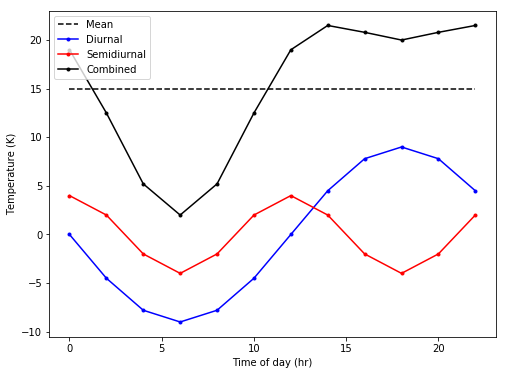

Amps:  [15.  9.  4.]
Hour of first maximum:  [18.0, 1.0855575107168599e-16]


In [2]:
# In this notebook we define a Fourier transform to perform daily amplitude and phase calculations
# To illustrate the concept we use an artificial dataset as follows.

# The synthetic data is a time series that is the sum of a constant (in time) term and two cosine
# functions with different frequencies. In a unit time interval, cosine function 1 completes one cycle
# and cosine function 2 completes two cycles. 

# These mimic two important modes of daily variability on Mars, known as the diurnal (1/day) and semidiurnal (2/day)
# tides.

# The functions have different amplitudes (ie the tidal strength). They also have an associated phase,
# which is the angle at which the cosine function achieves its first maximum in a day (ie the timing of 
# the first peak). On Mars both the amplitudes and phases of these tides change with season, and are influenced
# by global meterorological conditions (e.g. dust storms).

# The external functions hr_phase and phase_hr provide translations between two different ways of expressing
# phase: as an angle (more mathematically convenient but less intuitive) or as the hour of first maximum
# (more physically interpretable)

ts = 0; te = 1; timespersol = 12
#time = np.arange(ts*timespersol+1,te*timespersol+1)/timespersol
time = np.arange(ts*timespersol,te*timespersol)/timespersol

# Define the amplitudes of the constant term and the two tides / cosine functions
A0 = 15; A1 = 9; A2 = 4 # amplitudes
# Define the phases of the two tides in terms of hour of first maximum
# (relative to midnight):
H1 = -6; H2 = 0 

# convert from hour definition to angle definition of phase:
P1 = hr_phase(1,H1) 
P2 = hr_phase(2,H2) 

# Define synthetic time series as combination of the tides (and the background mean)
Amean = A0*np.ones(time.size)
A_1 = A1*np.cos(2*np.pi*time+P1)
A_2 = A2*np.cos(2*np.pi*time*2+P2)
S = A0 + A_1 + A_2

# Visualise the combined time series and its components
fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
ax.plot(24*time,Amean,'k--',label='Mean')
ax.plot(24*time,A_1,'b.-',label='Diurnal')
ax.plot(24*time,A_2,'r.-',label='Semidiurnal')
ax.plot(24*time,S,'k.-',label='Combined')
ax.set_xlabel('Time of day (hr)')
ax.set_ylabel('Temperature (K)')
ax.legend(loc='upper left')
plt.show()

# The Fourier transform dofft defined below allows us to 'invert' a given time series into the 
# set of cosine functions (each with a different frequency) that make it up. This will allow us
# to break down a meterorological time series to get the amplitudes and phases of the constituent
# tides.

def dofft(S,nt):
    '''
    A function to calculate the amplitude and phase of the
    '''
    sp = np.fft.rfft(S)/nt
    amps = np.abs(sp); amps[1:]*=2
    phases = np.angle(sp)
    return amps, phases

# Perform the Fourier Transform on our synthetic combined dataset
# We should get back the amplitudes and phases of the two tides
# that we defined earlier:

amps, phases = dofft(S,len(time))
# Convert phases to hour of first maximum of wave
hours = [phase_hr(1,phases[1])%24,phase_hr(2,phases[2])%24] # %24 converts the range from [-12,12] to [0.24]

print('Amps: ',amps[:3])
print('Hour of first maximum: ',hours)

In [3]:
# Having motivated the use of Fourier analysis, we apply it to the Martian 
# dataset to evaluate the performance of the ML algorithms in recreating the 
# evolving amplitude and phase structures of the diurnal and semidiurnal tides.

# As an exemplifier we use Carlos's surface pressure dataset

# Read in data from Carlos's model (LSTM)
pcarlos = pd.read_csv('data/FFT_carlos_insight_openmars_test_time_Psurf_pred.csv')
#pcarlos.drop(['Time','LT','CO2ice'],axis=1,inplace=True)
#target = df['Psurf']
#df.drop(labels=['Psurf'], axis=1,inplace = True)
#df.insert(1, 'Psurf', target)
#df['Time']= pd.to_datetime(df['Time'])

# Set start and end indices so that we have exact number of days, starting from midnight
# (hardcoded from looking at LT column in csv file)
sInd = 4
eInd = 16359

# Load relevant data 
lt_c = pcarlos['LT'][sInd:eInd+1]
ls_c = pcarlos['Ls'][sInd:eInd+1]
psurf_c = pcarlos['Psurf'][sInd:eInd+1]
psurfp_c = pcarlos['Psurf(Pred)'][sInd:eInd+1]
print(lt_c.shape,psurf_c.shape,psurfp_c.shape)

#print(pcarlos.head())
#pcarlos.describe()
#pcarlos.info()

(16356,) (16356,) (16356,)


In [4]:
# Calculate the number of days in the dataset (each day has tps=12 time points)
tps = 12 # number of time points in a day
ndays = int(len(psurf_c)/tps)

# Define arrays to hold the amplitude and phase values of the two tides
# over the course of the test dataset

# Arrays for the GCM 'real' data
ps_amp_diurnal_c = np.zeros((ndays,)) # amplitude of diurnal tide
ps_pha_diurnal_c = np.zeros((ndays,)) # phase of diurnal tide
ps_amp_sdiurnal_c = np.zeros((ndays,)) # amplitude of semidiurnal tide
ps_pha_sdiurnal_c = np.zeros((ndays,)) # phase of semidiurnal tide

# For the ML 'predicted' data - diurnal and semidiurnal tides
ps_amp_diurnal_pred_c = np.zeros((ndays,)) # amplitude of diurnal tide
ps_pha_diurnal_pred_c = np.zeros((ndays,)) # phase of diurnal tide
ps_amp_sdiurnal_pred_c = np.zeros((ndays,)) # amplitude of semidiurnal tide
ps_pha_sdiurnal_pred_c = np.zeros((ndays,)) # phase of semidiurnal tide

outlists = [
    [psurf_c,ps_amp_diurnal_c, ps_pha_diurnal_c, ps_amp_sdiurnal_c, ps_pha_sdiurnal_c],
    [psurfp_c,ps_amp_diurnal_pred_c, ps_pha_diurnal_pred_c, ps_amp_sdiurnal_pred_c, ps_pha_sdiurnal_pred_c]
]

# For each day, compute the amplitude, phase time series for diurnal and semidiurnal tides
for i in range(ndays): # going through each day ()
    for l in outlists: # doing the real and predicted datasets in turn
        ps = l[0] # get surface pressure        
        ps_amp_d = l[1] # diurnal amp
        ps_pha_d = l[2] # diurnal phase
        ps_amp_s = l[3] # semidiurnal amp
        ps_pha_s = l[4] # semidiurnal phase
        
        f = ps[i*tps:(i+1)*tps] # time series data for this day
        amps,phases = dofft(f,tps)
        ps_amp_d[i] = amps[1]
        ps_pha_d[i] = phase_hr(1,phases[1])%24
        ps_amp_s[i] = amps[2]
        ps_pha_s[i] = phase_hr(2,phases[2])%24      
    

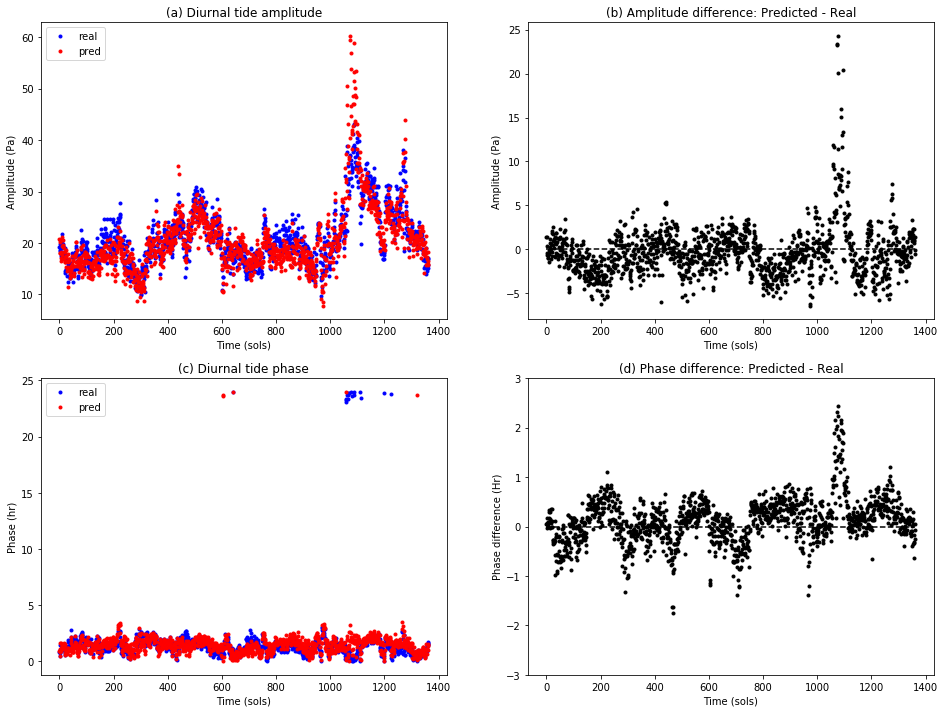

In [5]:
# Plot the results - diurnal amplitude and phase
days = np.arange(ndays)

fig2, ax2 = plt.subplots(2,2)
fig2.set_size_inches(16,12)

# Plot amplitudes
ax2[0,0].plot(days,ps_amp_diurnal_c,'b.',label='real')
ax2[0,0].plot(days,ps_amp_diurnal_pred_c,'r.',label='pred')
ax2[0,0].set_xlabel('Time (sols)')
ax2[0,0].set_ylabel('Amplitude (Pa)')
ax2[0,0].legend(loc='upper left')
ax2[0,0].set_title('(a) Diurnal tide amplitude')

# Compare amplitude differences
ax2[0,1].plot(ps_amp_diurnal_pred_c-ps_amp_diurnal_c,'k.')
ax2[0,1].plot([days[0],days[-1]],[0,0],'k--')
ax2[0,1].set_xlabel('Time (sols)')
ax2[0,1].set_ylabel('Amplitude (Pa)')
ax2[0,1].set_title('(b) Amplitude difference: Predicted - Real')

# Plot phases
ax2[1,0].plot(days,ps_pha_diurnal_c,'b.',label='real')
ax2[1,0].plot(days,ps_pha_diurnal_pred_c,'r.',label='pred')
ax2[1,0].set_xlabel('Time (sols)')
ax2[1,0].set_ylabel('Phase (hr)')
ax2[1,0].legend(loc='upper left')
ax2[1,0].set_title('(c) Diurnal tide phase')

# Plot phase differences
pha_diff = ps_pha_diurnal_pred_c-ps_pha_diurnal_c
# Wrap the phase differences where necessary to keep continuity
for i in range(ndays):
    if pha_diff[i]>12: # prediction is so much later that it can be considered 'early'
        pha_diff[i] = (ps_pha_diurnal_pred_c[i]-24)-ps_pha_diurnal_c[i]
    if pha_diff[i]<-12: # prediction is so much earlier that it can be considered 'late'
        pha_diff[i] = (ps_pha_diurnal_pred_c[i]+24)-ps_pha_diurnal_c[i]
                 
ax2[1,1].plot(pha_diff,'k.')
ax2[1,1].plot([days[0],days[-1]],[0,0],'k--')
ax2[1,1].set_ylim([-3,3])
ax2[1,1].set_xlabel('Time (sols)')
ax2[1,1].set_ylabel('Phase difference (Hr)')
ax2[1,1].set_title('(d) Phase difference: Predicted - Real')

plt.show()

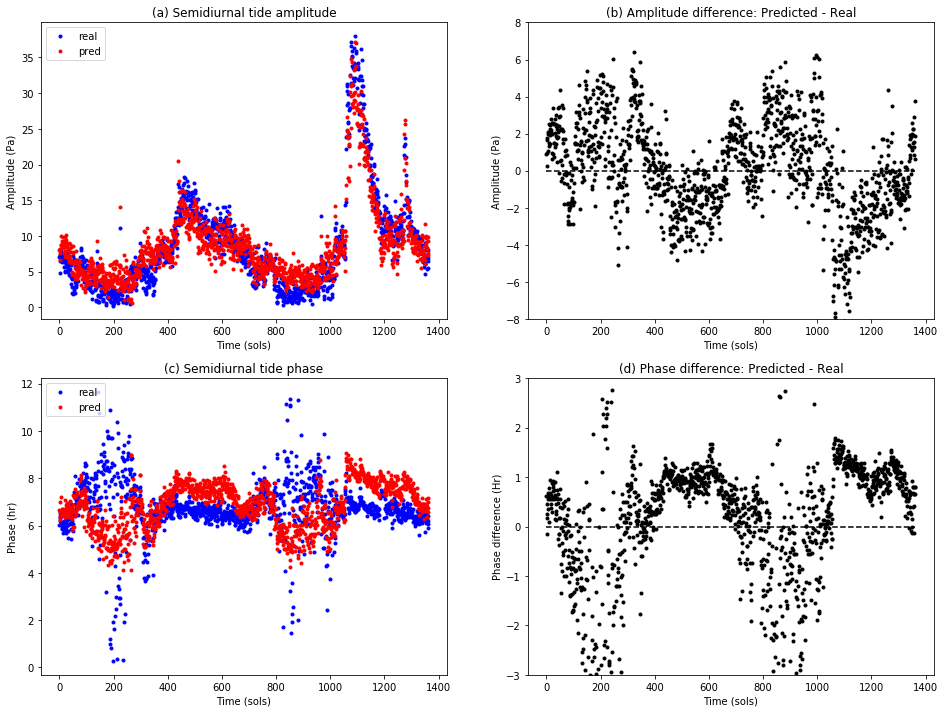

In [6]:
# The same calculation can be repeated for the semidiurnal tide:

fig3, ax3 = plt.subplots(2,2)
fig3.set_size_inches(16,12)
ax3[0,0].plot(days,ps_amp_sdiurnal_c,'b.',label='real')
ax3[0,0].plot(days,ps_amp_sdiurnal_pred_c,'r.',label='pred')
ax3[0,0].set_xlabel('Time (sols)')
ax3[0,0].set_ylabel('Amplitude (Pa)')
ax3[0,0].legend(loc='upper left')
ax3[0,0].set_title('(a) Semidiurnal tide amplitude')

ax3[0,1].plot(ps_amp_sdiurnal_pred_c-ps_amp_sdiurnal_c,'k.')
ax3[0,1].plot([days[0],days[-1]],[0,0],'k--')
ax3[0,1].set_ylim([-8,8])
ax3[0,1].set_xlabel('Time (sols)')
ax3[0,1].set_ylabel('Amplitude (Pa)')
ax3[0,1].set_title('(b) Amplitude difference: Predicted - Real')

ax3[1,0].plot(days,ps_pha_sdiurnal_c,'b.',label='real')
ax3[1,0].plot(days,ps_pha_sdiurnal_pred_c,'r.',label='pred')
ax3[1,0].set_xlabel('Time (sols)')
ax3[1,0].set_ylabel('Phase (hr)')
ax3[1,0].legend(loc='upper left')
ax3[1,0].set_title('(c) Semidiurnal tide phase')

# To compare phase differences
pha_diff = ps_pha_sdiurnal_pred_c-ps_pha_sdiurnal_c
# Wrap the phase differences where necessary to keep continuity
for i in range(ndays):
    if pha_diff[i]>12: # prediction is so much later that it can be considered 'early'
        pha_diff[i] = (ps_pha_sdiurnal_pred_c[i]-24)-ps_pha_sdiurnal_c[i]
    if pha_diff[i]<-12: # prediction is so much earlier that it can be considered 'late'
        pha_diff[i] = (ps_pha_sdiurnal_pred_c[i]+24)-ps_pha_sdiurnal_c[i]
                 
ax3[1,1].plot(pha_diff,'k.')
ax3[1,1].plot([days[0],days[-1]],[0,0],'k--')
ax3[1,1].set_ylim([-3,3])
ax3[1,1].set_xlabel('Time (sols)')
ax3[1,1].set_ylabel('Phase difference (Hr)')
ax3[1,1].set_title('(d) Phase difference: Predicted - Real')

plt.show()

In [7]:
# (ANALYSIS INCOMPLETE) Read in data from Sagar's model (LSTNet)
psagar_test = pd.read_csv('data/FFT_sagar_test_data.csv')
psagar_pred = pd.read_csv('data/FFT_sagar_predicted_data.csv')

# Load time data
time_s = psagar_test['Time']

## Sagar dataset only has time in UTC format
## convert back to time values on Mars to pick out
## an exact number of days starting from midnight

# Initialise martian time conversion function
tcx = tc(tps,30) # the arguments tps=12 and 30 don't actually matter here

## Get time values on Mars (convert from UTC) for sagar data
##timeshort = time_s[13:] # To look for first midnight index
#timeshort = time_s[-13:] # To look for last midnight index
#print(timeshort)
#for time in timeshort:
#    # separate components
#    tarr = datetime.strptime(time,"%Y-%m-%d %H:%M:%S")
#    utc = [tarr.date().year,tarr.date().month,tarr.date().day,tarr.time().hour,tarr.time().minute,tarr.time().second]
#    soll = tcx.convert('utc','soll',utc)
#    print(utc,soll)

# Set start and end indices so that we have exact number of days
# (hardcoded from looking at converted times, see above commented code)
sInd = 9
eInd = 8852

# Load atmospheric fields (whole number of days)
# Pressure
psurf_s = psagar_test['Psurf'][sInd:eInd+1]
psurfp_s = psagar_pred['Psurf'][sInd:eInd+1]
# u
u_s = psagar_test['u_wind'][sInd:eInd+1]
up_s = psagar_pred['u_wind'][sInd:eInd+1]
# v
v_s = psagar_test['v_wind'][sInd:eInd+1]
vp_s = psagar_pred['v_wind'][sInd:eInd+1]
# temp
t_s = psagar_test['temp'][sInd:eInd+1]
tp_s = psagar_pred['temp'][sInd:eInd+1]